In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [142]:
# reflect an existing database into a new model
Base = automap_base()


In [7]:
# reflect the tables
Base.prepare(autoload_with=engine)


In [8]:
# pandas tables
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
station_data = pd.read_sql("SELECT * FROM station", conn)
measurement_data.head()
station_data.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(func.max(measurement.date)).all()

[('2017-08-23',)]

In [103]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
query_end_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
measurement_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date <= recent_date).\
    filter(measurement.date >= query_end_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurement_df = pd.DataFrame(measurement_data, columns = ['Precipitation','Date'])

# Sort the dataframe by date
measurement_df.sort_values(by='Date',ascending=True,inplace=True)
measurement_df.head()


,Precipitation,Date
0,2016-08-23,0.0
1127,2017-03-10,0.0
1130,2017-03-15,0.0
1136,2017-03-31,0.0
1139,2017-04-05,0.0


<Axes: xlabel='Date', ylabel='Inches'>

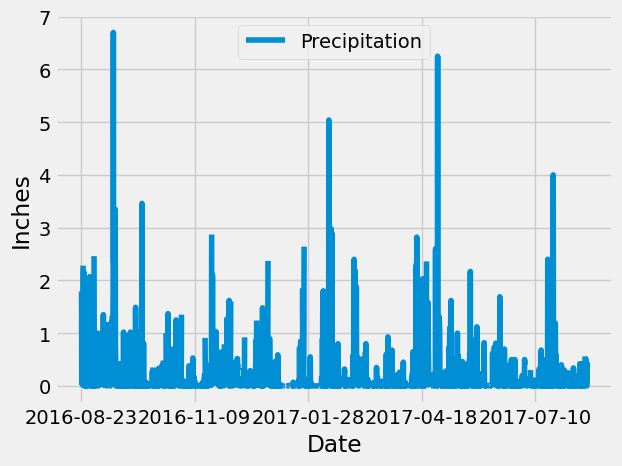

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(kind="line",x='Date',y='Precipitation',xlabel='Date',ylabel='Inches',legend=True)

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurement_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(measurement.station.distinct())).all()

[(9,)]

In [140]:
session.query(func.count(measurement.station)).filter(measurement.date <= recent_date).filter(measurement.date >= query_end_date).filter(measurement.station == 'USC00519281').all()

[(352,)]

In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [128]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(func.max(measurement.tobs)).where(measurement.station == 'USC00519281').all()
min_temp = session.query(func.min(measurement.tobs)).where(measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(measurement.tobs)).where(measurement.station == 'USC00519281').all()
print(f"USC00519281 Stats: Highest temperature - {max_temp}. Lowest temperature - {min_temp}. Average temperature - {avg_temp}")

USC00519281 Stats: Highest temperature - [(85.0,)]. Lowest temperature - [(54.0,)]. Average temperature - [(71.66378066378067,)]


In [130]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs,func.count(measurement.tobs)).filter(measurement.date <= recent_date).filter(measurement.date >= query_end_date).filter(measurement.station == 'USC00519281').group_by(measurement.tobs).all()
temp_data

[(59.0, 3),
 (60.0, 2),
 (61.0, 1),
 (62.0, 6),
 (63.0, 4),
 (64.0, 3),
 (65.0, 7),
 (66.0, 5),
 (67.0, 15),
 (68.0, 12),
 (69.0, 19),
 (70.0, 22),
 (71.0, 18),
 (72.0, 22),
 (73.0, 18),
 (74.0, 39),
 (75.0, 33),
 (76.0, 33),
 (77.0, 31),
 (78.0, 22),
 (79.0, 18),
 (80.0, 11),
 (81.0, 4),
 (82.0, 3),
 (83.0, 1)]

In [131]:
temperature_df = pd.DataFrame(temp_data, columns = ['Temperature','Count'])

In [132]:
bins = [54, 56.583,59.16,61.75,64.33,66.916,69.5,72.08,74.66,77.25,79.83,82.416,85]
temperature_df["Temperature"] = pd.cut(temperature_df["Temperature"], bins, include_lowest=True)

In [135]:
temperature_df["Count"].sum()

352

<Axes: xlabel='Temperature', ylabel='Frequency'>

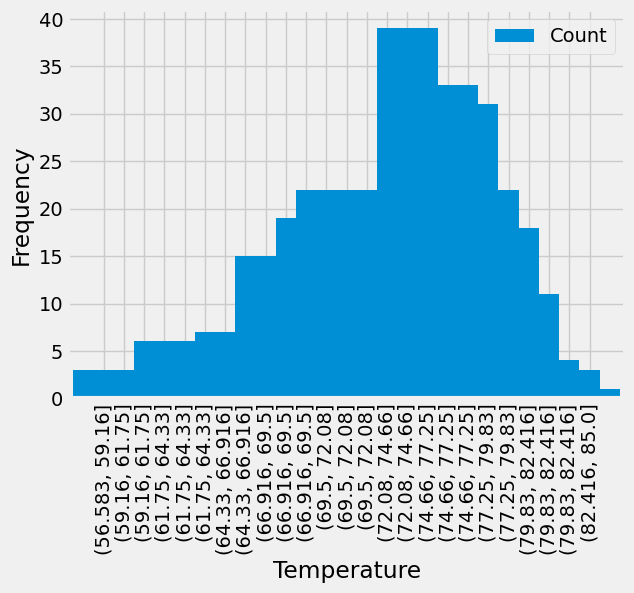

In [141]:
temperature_df.plot(kind="bar",x="Temperature",y='Count',xlabel='Temperature',ylabel='Frequency', width = 3, legend=True)

# Close Session

In [21]:
# Close Session
session.close()